In [ ]:
import csv
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
review=pd.read_csv("/content/drive/MyDrive/nlp_data/review_topic.csv")

Mounted at /content/drive


In [ ]:
review.dropna(inplace=True)
review.head()

,review_id,business_id,stars,text,processed_text,Topic,topic_name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,if you decide to eat here just be aware it is ...,decide eat aware go take hour begin end try mu...,3,waiting time
1,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious our favorite is ...,wow yummy different delicious favorite lamb cu...,2,Asian food
2,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,1.0,i am a long term frequent customer of this est...,long term frequent customer establishment go o...,3,waiting time
3,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,5.0,amazingly amazing wings and homemade bleu chee...,amazingly amaze wing homemade bleu cheese ribe...,1,dinner and dessert
4,8JFGBuHMoiNDyfcxuWNtrA,RZtGWDLCAtuipwaZ-UfjmQ,4.0,good foodloved the gnocchi with marinara the b...,good foodloved gnocchi marinara bake eggplant ...,1,dinner and dessert


In [ ]:
review_mod = review.sample(n=250000, random_state=43)
review_mod["sentiment"] = ""
review_mod.loc[review["stars"] >3, "sentiment"] = 1
review_mod.loc[review["stars"] <=3, "sentiment"] = 0
review_mod.head()

,review_id,business_id,stars,text,processed_text,Topic,topic_name,sentiment
19559,vY7DDA2yDLjqJtdE3hw4Mw,LnZvGYbqozanOSevcftnrw,4.0,came here for the first time on a sunday at a...,come first time sunday two friend werent many ...,4,Drinks and staff services,1
646142,Fn44ZXd5kqhXNK-8EJyHQw,3yM-H86cdCHUGW7mwCjE6A,2.0,its good enough when i want a primo hoagie but...,good enough want primo hoagie well primo hoagi...,5,pizza,0
801267,deTVKlp38FtXhS_31uwp_w,6wqxuBt2InDipRuUj8BNuQ,5.0,i live in the bay area and love nothing more t...,live bay area love nothing good strong espress...,4,Drinks and staff services,1
1172529,mWWXwULMA5yXscpS69ypkQ,yxQs5gSf0-8cEd6YMgSjbw,1.0,i came here about a year ago with da homies th...,come year ago da homies absolute shit host mea...,3,waiting time,0
675485,_MCJK_BoOSLChsC5BNzskA,gdyMIBAitsQubj0OEJoiMg,4.0,my friend and i discovered this gem at random ...,friend discover gem random tourist order chees...,0,fastfood like burgers and sandwichs,1


In [ ]:
X = review_mod['processed_text']
y = review_mod.sentiment
y=y.astype('int')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [ ]:
y_train.shape

(200000,)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=4500,max_df=0.85,min_df=6)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Models

In [ ]:
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
#Naive Bayes Model
nb_classifier = MultinomialNB()
nbm=nb_classifier.fit(X_train_tfidf, y_train)
nb_train_score = nb_classifier.score(X_test_tfidf, y_test)
print(nb_train_score)

0.85632


In [ ]:
joblib.dump(nb_classifier, '/content/drive/MyDrive/nlp_data/TFIDF_NB_Sentiment_Modell.model')

['/content/drive/MyDrive/nlp_data/TFIDF_NB_Sentiment_Modell']

In [ ]:
y_pred = nbm.predict(X_test_tfidf)
nbm_precision = precision_score(y_test, y_pred)
nbm_f1 = f1_score(y_test, y_pred)
print("Precision:", nbm_precision)
print("F1 Score:", nbm_f1)

Precision: 0.845200665803588
F1 Score: 0.899050081501883


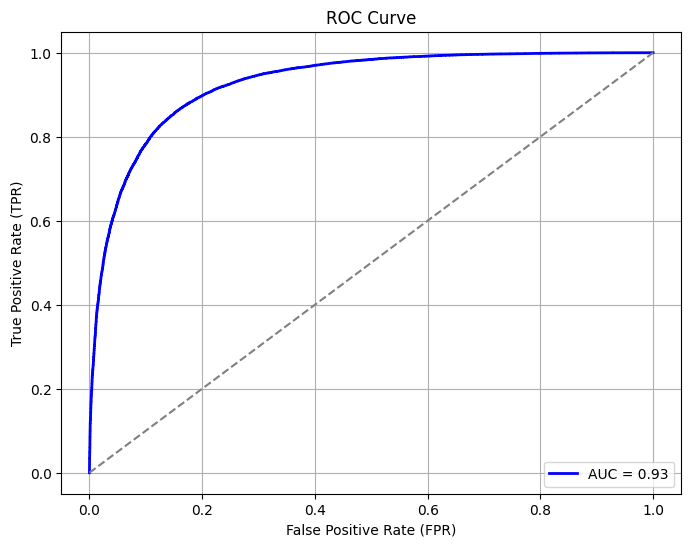

In [ ]:
#ROC Curve
y_pred_proba = nbm.predict_proba(X_test_tfidf)
# compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# compute ROC AUC
nb_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
# draw ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {nb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
#SVM Model
from sklearn.svm import SVC
svm_classifier = SVC(C=0.95, kernel="linear", shrinking=True, probability=True)
svm = svm_classifier.fit(X_train_tfidf, y_train)
svm_test_score = svm_classifier.score(X_test_tfidf, y_test)
print(svm_test_score)
joblib.dump(svm_classifier, '/content/drive/MyDrive/tfidf_svm1_sentiment.model')

0.89556


In [ ]:
#svm = joblib.load('/content/drive/MyDrive/nlp_data/tfidf_svm1_sentiment.model')

In [ ]:
y_pred = svm.predict(X_test_tfidf)
svm_precision = precision_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)
print("Precision:", svm_precision)
print("F1 Score:", svm_f1)

Precision: 0.845200665803588
F1 Score: 0.899050081501883


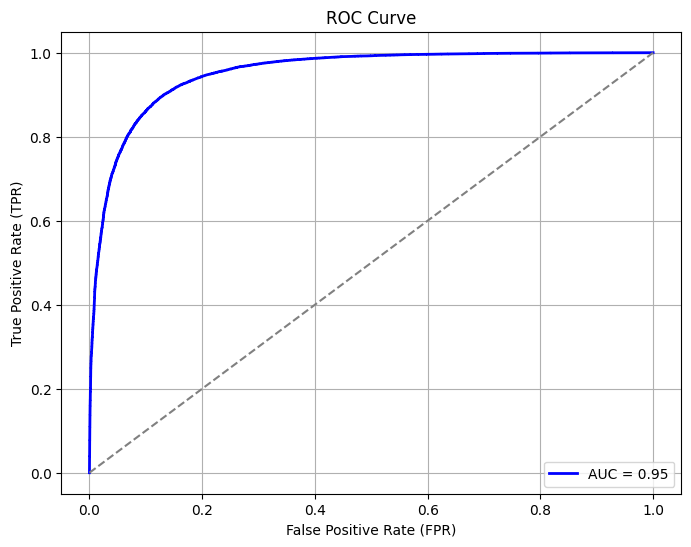

In [ ]:
#ROC Curve
y_pred_proba = svm.predict_proba(X_test_tfidf)
# compute ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
# compute ROC AUC
nb_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
# draw ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {nb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

|          | NaiveBayes | SVM | LSTM |   |
|----------|------------|-----|------|---|
| Accuracy |  0.856          |   0.895  |  0.833    |   |
| AUC      |  0.93          |  0.95   |    0.90  |   |
| Precision         |  0.845          | 0.845    | 0.837     |   |
| F1 score         |  0.899       | 0.899    |  0.868    |   |

Apply the model to the entire dataset

In [ ]:
svm = joblib.load('/content/drive/MyDrive/nlp_data/tfidf_svm1_sentiment.model')
review_tfidf = tfidf_vectorizer.fit_transform(review["processed_text"])
proba = svm.predict_proba(review_tfidf)

In [ ]:
#review['sentiment_prediction'] = predictions
review['sentiment_probability'] = proba[:, 1]
review.head()

,review_id,business_id,stars,text,processed_text,Topic,topic_name,sentiment_probability
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,if you decide to eat here just be aware it is ...,decide eat aware go take hour begin end try mu...,3,waiting time,0.213844
1,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious our favorite is ...,wow yummy different delicious favorite lamb cu...,2,Asian food,0.999990
2,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,1.0,i am a long term frequent customer of this est...,long term frequent customer establishment go o...,3,waiting time,0.643294
3,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,5.0,amazingly amazing wings and homemade bleu chee...,amazingly amaze wing homemade bleu cheese ribe...,1,dinner and dessert,1.000000
4,8JFGBuHMoiNDyfcxuWNtrA,RZtGWDLCAtuipwaZ-UfjmQ,4.0,good foodloved the gnocchi with marinara the b...,good foodloved gnocchi marinara bake eggplant ...,1,dinner and dessert,0.301108


In [ ]:
review.head(50)

,review_id,business_id,stars,text,processed_text,Topic,topic_name,sentiment_probability
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,if you decide to eat here just be aware it is ...,decide eat aware go take hour begin end try mu...,3,waiting time,0.213844
1,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious our favorite is ...,wow yummy different delicious favorite lamb cu...,2,Asian food,0.999990
2,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,1.0,i am a long term frequent customer of this est...,long term frequent customer establishment go o...,3,waiting time,0.643294
3,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,5.0,amazingly amazing wings and homemade bleu chee...,amazingly amaze wing homemade bleu cheese ribe...,1,dinner and dessert,1.000000
4,8JFGBuHMoiNDyfcxuWNtrA,RZtGWDLCAtuipwaZ-UfjmQ,4.0,good foodloved the gnocchi with marinara the b...,good foodloved gnocchi marinara bake eggplant ...,1,dinner and dessert,0.301108
5,oyaMhzBSwfGgemSGuZCdwQ,YtSqYv1Q_pOltsVPSx54SA,5.0,tremendous service big shout out to douglas th...,tremendous service big shout douglas complemen...,4,Drinks and staff services,0.972156
6,Xs8Z8lmKkosqW5mw_sVAoA,eFvzHawVJofxSnD7TgbZtg,5.0,my absolute favorite cafe in the city their bl...,absolute favorite cafe city black white latte ...,4,Drinks and staff services,0.995650
7,G_5UczbCBJriUAbxz3J7Tw,x4XdNhp0Xn8lOivzc77J-g,5.0,best thai food in the area everything was auth...,best thai food area everything authentic delic...,2,Asian food,1.000000
8,DyrAIuKl60j_X8Yrrv-kpg,MWmXGQ98KbRo3vsS5nZhMA,5.0,i recently had dinner here with my wife over t...,recently dinner wife weekend could please meal...,1,dinner and dessert,0.995873
9,-P5E9BYUaK7s3PwBF5oAyg,bMratNjTG5ZFEA6hVyr-xQ,5.0,first time there and it was excellent it feels...,first time excellent feel like enter someone h...,4,Drinks and staff services,0.995678


import numpy as np
from google.colab import autoviz
df_2788442709972756228 = autoviz.get_df('df_2788442709972756228')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_2788442709972756228, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_961347747096088977 = autoviz.get_df('df_961347747096088977')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_961347747096088977, *['stars'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1852933908587076535 = autoviz.get_df('df_1852933908587076535')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1852933908587076535, *['Topic'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4568665520450826801 = autoviz.get_df('df_4568665520450826801')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_4568665520450826801, *['sentiment_probability'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4661539058286466031 = autoviz.get_df('df_4661539058286466031')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4661539058286466031, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1430218373418980830 = autoviz.get_df('df_1430218373418980830')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_1430218373418980830, *['stars'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3939642217176439283 = autoviz.get_df('df_3939642217176439283')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_3939642217176439283, *['Topic'], **{})
chart

import numpy as np
from google.colab import autoviz
df_6713556006401330736 = autoviz.get_df('df_6713556006401330736')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_6713556006401330736, *['sentiment_probability'], **{})
chart

import numpy as np
from google.colab import autoviz
df_8304657620774037562 = autoviz.get_df('df_8304657620774037562')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_8304657620774037562, *['topic_name'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1648945959568814804 = autoviz.get_df('df_1648945959568814804')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_1648945959568814804, *[[['index', 'stars'], ['stars', 'Topic'], ['Topic', 'sentiment_probability']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_471493709291480780 = autoviz.get_df('df_471493709291480780')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_471493709291480780, *['index', 'topic_name'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_5966185343604743623 = autoviz.get_df('df_5966185343604743623')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_5966185343604743623, *['stars', 'topic_name'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_5437262180433973275 = autoviz.get_df('df_5437262180433973275')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_5437262180433973275, *['Topic', 'topic_name'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_135199000542407418 = autoviz.get_df('df_135199000542407418')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_135199000542407418, *['sentiment_probability', 'topic_name'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_5359808319508832257 = autoviz.get_df('df_5359808319508832257')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_5359808319508832257, *['index', 'stars', 'topic_name'], **{})
chart

import numpy as np
from google.colab import autoviz
df_62270313020975748 = autoviz.get_df('df_62270313020975748')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_62270313020975748, *['index', 'Topic', 'topic_name'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2991976342124609306 = autoviz.get_df('df_2991976342124609306')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_2991976342124609306, *['index', 'sentiment_probability', 'topic_name'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3324925438892682980 = autoviz.get_df('df_3324925438892682980')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_3324925438892682980, *['index', 'count()', 'topic_name'], **{})
chart

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
review.to_csv('/content/drive/MyDrive/nlp_data/review_topic_prob.csv', index=False)